## Load and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('train.csv')

# Display the first few rows
print(df.head())

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  


In [2]:
# Summary of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None


In [3]:
# Convert datetime column to proper datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract relevant time features from the datetime column
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# Drop unnecessary columns (datetime, casual, registered)
df.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)

In [4]:
# Descriptive statistics
print(df.describe())

             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed         count          hour  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395    191.574132     11.541613   
std        8.474601     19.245033      8.164537    181.14445

## EDA (Exploratory Data Analysis)

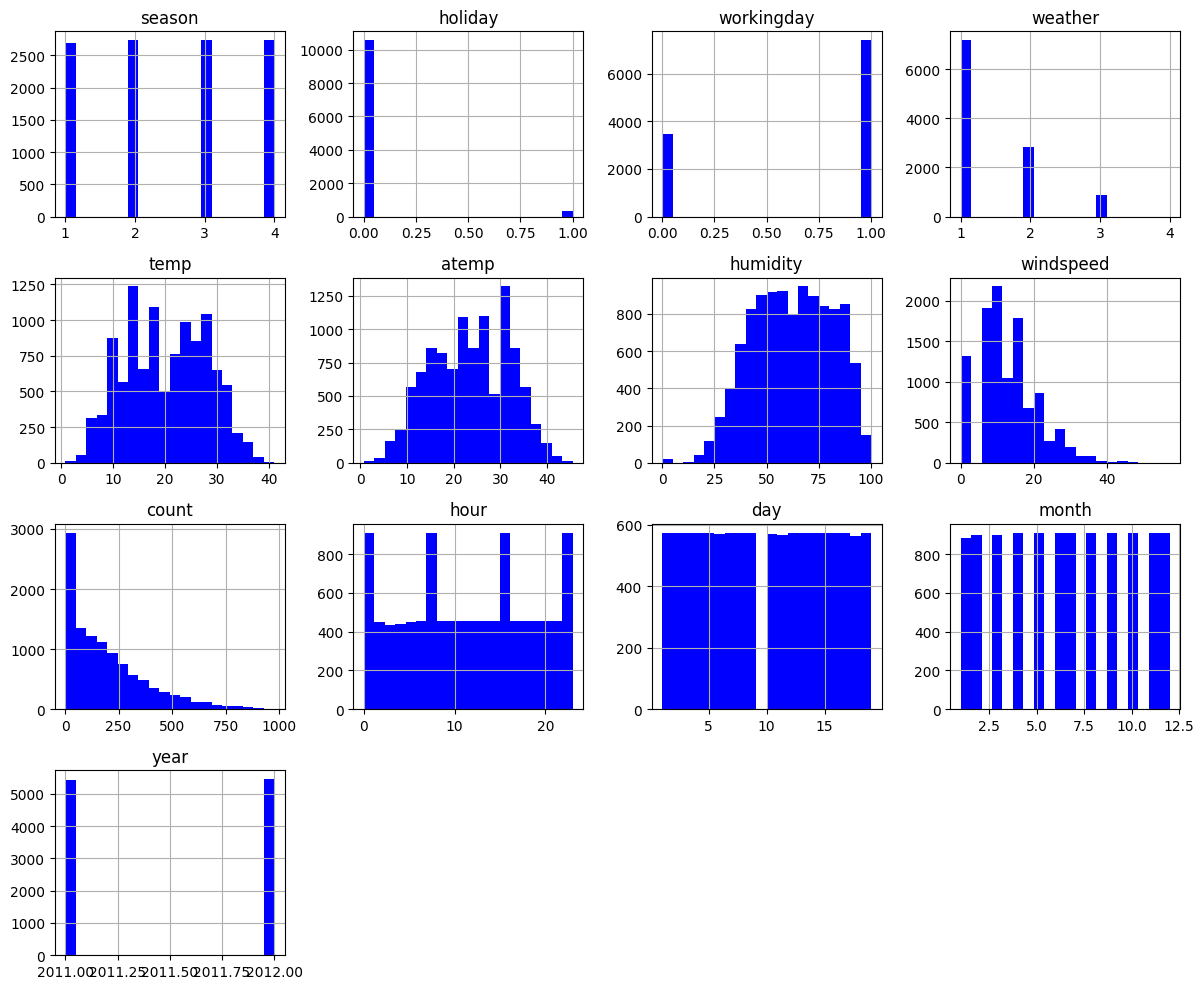

In [5]:
# Plot distributions of numeric features
df.hist(bins=20, figsize=(12, 10), color='blue')
plt.tight_layout()
plt.show()

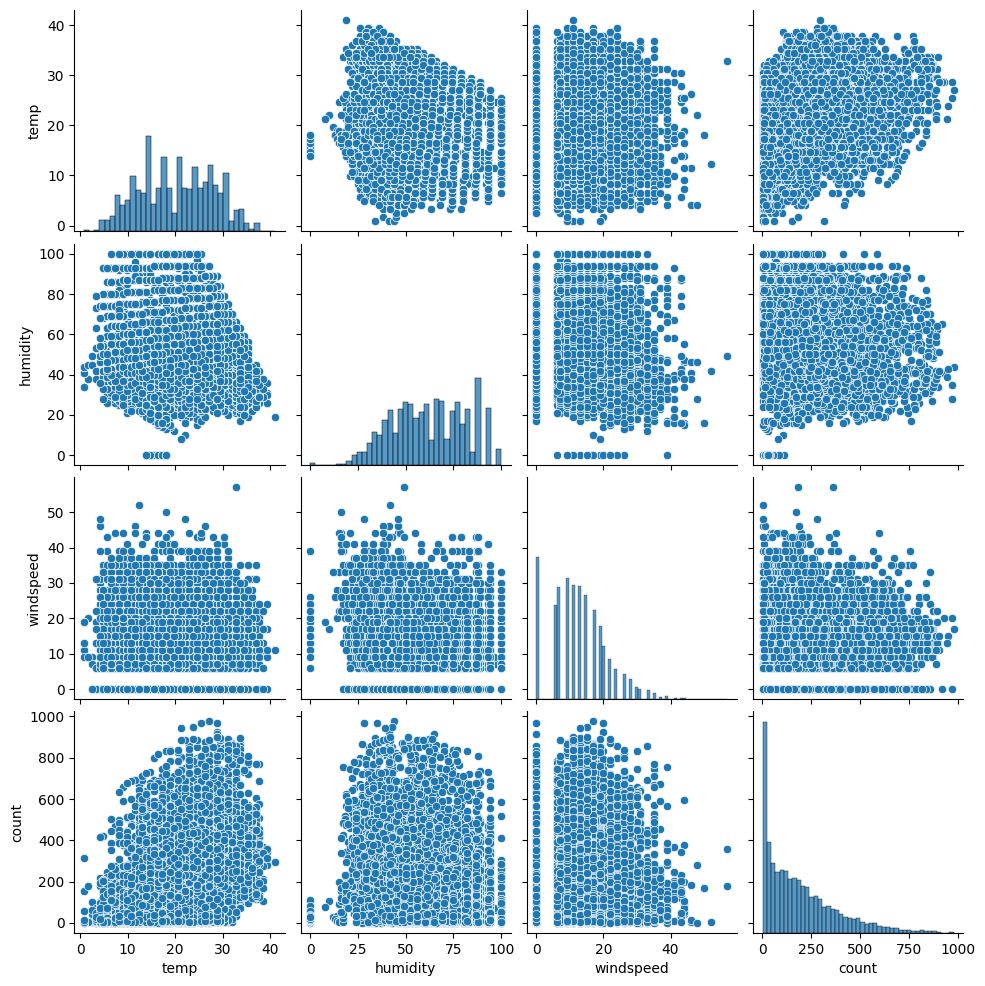

In [6]:
# Visualize the relationships
sns.pairplot(df[['temp', 'humidity', 'windspeed', 'count']])
plt.show()

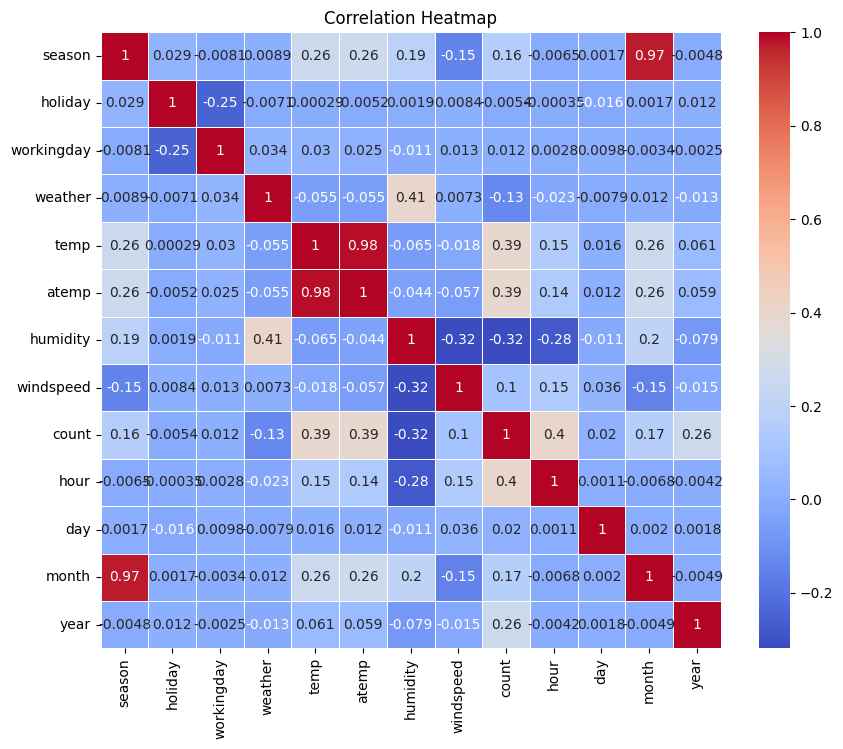

In [7]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

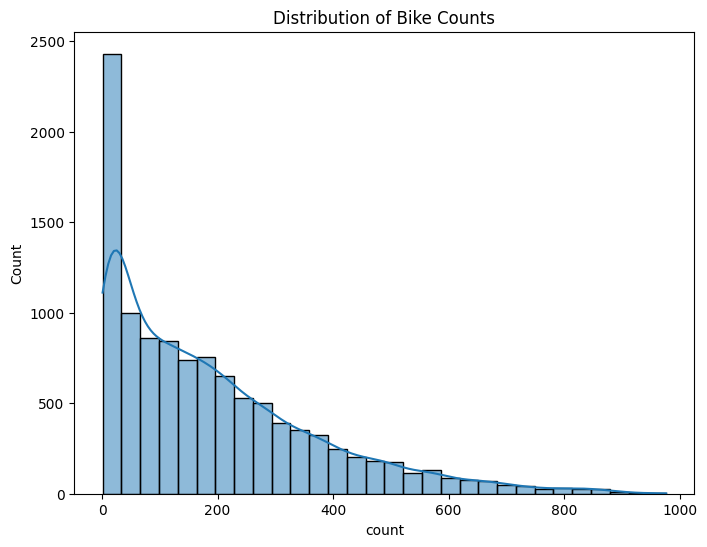

In [8]:
# Distribution of the target variable 'count'
plt.figure(figsize=(8, 6))
sns.histplot(df['count'], kde=True, bins=30)
plt.title('Distribution of Bike Counts')
plt.show()

In [9]:
# Check for missing values
print(df.isnull().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
hour          0
day           0
month         0
year          0
dtype: int64


## Preprocess the Data

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define feature matrix (X) and target (y for regression and classification)
X = df.drop(['count'], axis=1)  # Drop the target 'count' for feature matrix
y_regression = df['count']  # Target for regression

In [11]:
# OneHotEncode categorical columns like 'season' and 'weather'
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['temp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year']),
    ('cat', OneHotEncoder(), ['season', 'weather', 'holiday', 'workingday'])
])

In [12]:
# Split the data into training and test sets for regression
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)

## Gaussian Process Regression

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define the kernel: RBF kernel with a constant kernel component
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

In [14]:
# Create a pipeline with preprocessing and GPR
gpr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gpr', GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42))
])

In [15]:
# Train the model
gpr_pipeline.fit(X_train, y_train_reg)

C:\Users\nhyuj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temp', 'humidity',
                                                   'windspeed', 'hour', 'day',
                                                   'month', 'year']),
                                                 ('cat', OneHotEncoder(),
                                                  ['season', 'weather',
                                                   'holiday',
                                                   'workingday'])])),
                ('gpr',
                 GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=10,
                                          random_state=42))])

In [16]:
# Predict on test data
y_pred_reg = gpr_pipeline.predict(X_test)

In [17]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
print('Mean Squared Error:', mean_squared_error(y_test_reg, y_pred_reg))
print('R^2 Score:', r2_score(y_test_reg, y_pred_reg))

Mean Squared Error: 19200.544427810983
R^2 Score: 0.41828758336366345


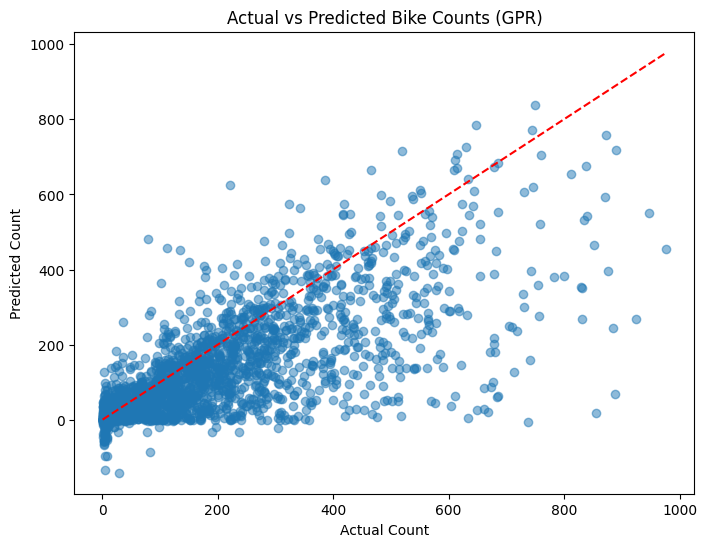

In [18]:
# Plot actual vs predicted values for regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], 'r--')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Bike Counts (GPR)')
plt.show()

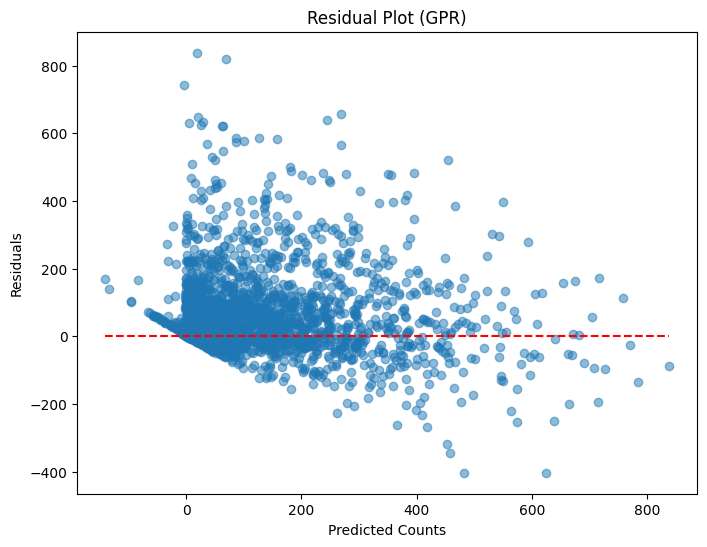

In [19]:
# Residuals = actual values - predicted values
residuals = y_test_reg - y_pred_reg

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_reg, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred_reg), xmax=max(y_pred_reg), color='r', linestyle='--')
plt.xlabel('Predicted Counts')
plt.ylabel('Residuals')
plt.title('Residual Plot (GPR)')
plt.show()

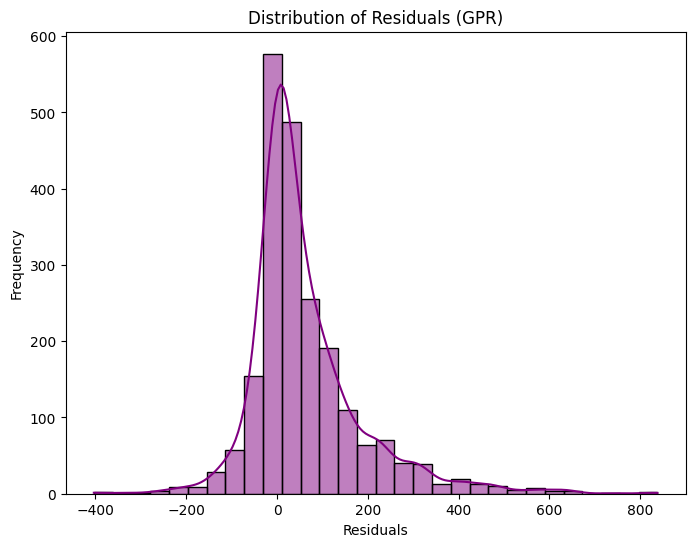

In [20]:
# Plot the distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Distribution of Residuals (GPR)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

## Gaussian Process Classifier

In [22]:
# Create categories: Low demand (<100), Medium demand (100-300), High demand (>300)
bins = [0, 100, 300, df['count'].max()]
labels = [0, 1, 2]  # 0: Low, 1: Medium, 2: High demand
df['demand_category'] = pd.cut(df['count'], bins=bins, labels=labels)

# Prepare features and target for classification
X_class = df[['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'hour']]
y_class = df['demand_category']

# Split the dataset into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_class = scaler.fit_transform(X_train_class)
X_test_class = scaler.transform(X_test_class)

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# Adjust the noise level lower bound to a smaller value
kernel = DotProduct() + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e1))

# Initialize the GaussianProcessClassifier model with the modified kernel
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)

In [23]:
# Fit the model
gpc.fit(X_train_class, y_train_class)

GaussianProcessClassifier(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=0.0001),
                          random_state=42)

In [24]:
# Predict on the test set
y_pred_class = gpc.predict(X_test_class)

In [26]:
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test_class, y_pred_class)}")
print("Classification Report:\n", classification_report(y_test_class, y_pred_class))

Accuracy: 0.6230863441518677
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.82      0.74      1273
           1       0.57      0.61      0.59      1262
           2       0.62      0.31      0.41       731

    accuracy                           0.62      3266
   macro avg       0.62      0.58      0.58      3266
weighted avg       0.62      0.62      0.61      3266



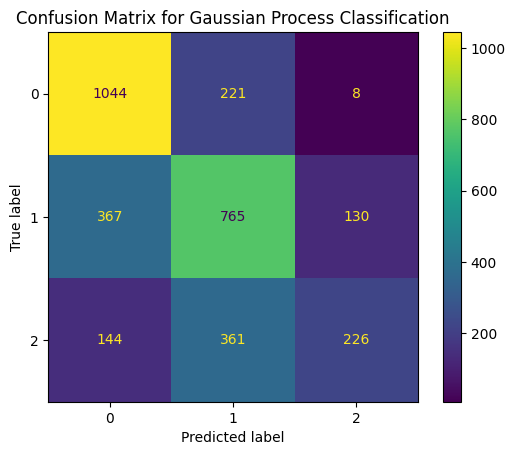

In [27]:
# Confusion matrix visualization
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gpc, X_test_class, y_test_class)
plt.title("Confusion Matrix for Gaussian Process Classification")
plt.show()

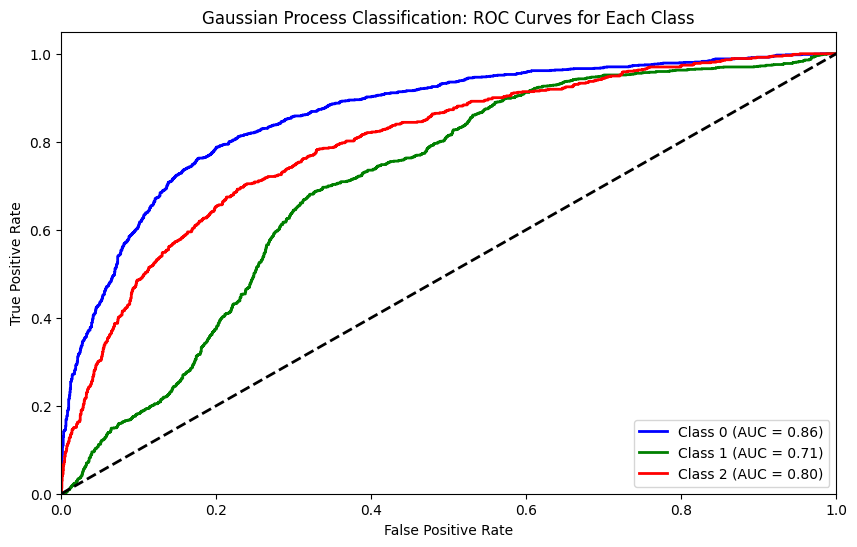

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output (one-vs-rest for each class)
y_test_binarized = label_binarize(y_test_class, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# One-vs-rest classifier
gpc_ovr = OneVsRestClassifier(GaussianProcessClassifier(kernel=kernel, random_state=42))
y_score = gpc_ovr.fit(X_train_class, y_train_class).predict_proba(X_test_class)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Add a diagonal line (for random predictions)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Process Classification: ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

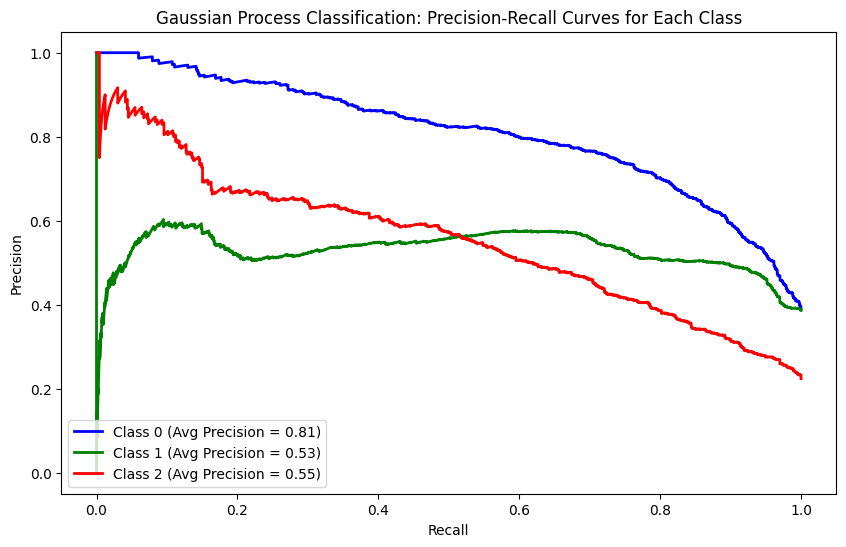

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for i in range(n_classes):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, 
             label=f'Class {i} (Avg Precision = {average_precision[i]:.2f})')

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gaussian Process Classification: Precision-Recall Curves for Each Class')
plt.legend(loc="lower left")
plt.show()